## Homework - PROJECT 3:
This notebook performs spatial proteomics clustering and analysis using CellCharter.  
It assumes that the following features were **precomputed and included** in the loaded `adata`, according to the second lab scenario:

- **`obsm['avg_marker_expression']`**:  
  Spatially smoothed mean marker expression per cell, computed by averaging over each cell's spatial neighborhood.

- **`obsm['cell_type_hist']`**:  
  Cell type histograms representing the frequency of each cell type in the spatial neighborhood of every cell.

- **`obsp['spatial_connectivities']`**:  
  Sparse spatial neighbor graph computed using Squidpy, used to define neighborhood relationships between cells.


In [8]:
import cellcharter as cc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import anndata

In [9]:
TRAIN_ANNDATA_PATH = './train_adata.h5ad'

adata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
adata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

## 1) PCA on marker expressions

In this section we perform dimensionality reduction on marker expressions to speed up computation down the road

In [13]:
from sklearn.decomposition import PCA

# Extract raw expression data
exprs = adata.layers['exprs']

# Step 1: Normalize each cell to have total counts = 1e6
cell_sums = exprs.sum(axis=1, keepdims=True)
normalized_exprs = (exprs / cell_sums) * 1e6

# Step 2: Log1p transform
log_normalized_exprs = np.log1p(normalized_exprs)

# Store normalized data
adata.layers['exprs_normalized'] = log_normalized_exprs

# Step 3: PCA
pca = PCA(n_components=0.95)
expr_pca = pca.fit_transform(log_normalized_exprs)

Explained 0.9514 of variance in 40 markers with 25 components


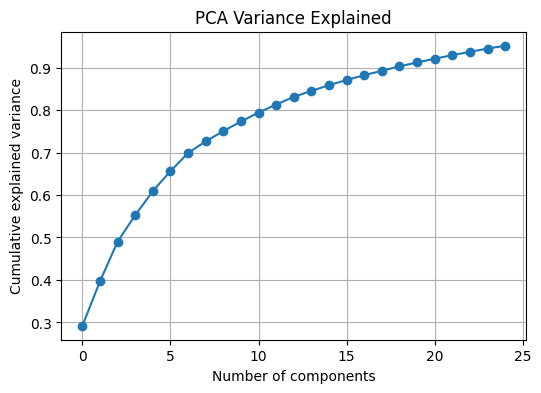

In [14]:
explained_variance = pca.explained_variance_ratio_

total_variance_explained = explained_variance.sum()
num_components = pca.n_components_
num_markers = len(adata.var['marker'])

print(f"Explained {total_variance_explained:.4f} of variance in {num_markers} markers with {num_components} components")

plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

In [15]:
# Store PCA result in the expected field
adata.obsm["X_PCA"] = expr_pca

## 2) Neighbor Aggregation

In [16]:
# create the 'spatial' column expected by squidpy
adata.obsm['spatial'] = adata.obs[['Pos_X', 'Pos_Y']].values

In [17]:
# compute the graph and remove artifacts of Delaunay triangulation
sq.gr.spatial_neighbors(
    adata,
    library_key='sample_id',
    coord_type='generic',
    delaunay=True,             
    spatial_key='spatial',
    key_added='spatial',
    percentile=99
)


`n_layers` = 3 was selected based on the tutorial.

Number 3 does a good job of capturing more that the immediate surroundings of every cell while avoiding the loss of local identity.

In [18]:
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_PCA', out_key='X_cellcharter', sample_key='sample_id')

  0%|          | 0/132 [00:00<?, ?it/s]

## 3) Cluster Selection

In [27]:
# defining model parameters
model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator':'gpu'
            },
         }

# defining AutoK model to find appropriate number of clusters
autok = cc.tl.ClusterAutoK(
    n_clusters=(10,30), 
    max_runs=10,
    convergence_tol=0.001,
    model_params = model_params,
)

In [26]:
# casting to float32
adata.obsm["X_cellcharter"] = adata.obsm["X_cellcharter"].astype(np.float32)

In [28]:
# clustering the data using AutoK
import time
start = time.time()
autok.fit(adata[::20], use_rep='X_cellcharter') #downsampling by a factor of 20 to speed up the computation

print("Finished clustering in: ", time.time()-start, "s")

Iteration 1/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 2/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 3/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 4/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 5/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 6/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 7/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 8/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 9/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 10/10


  0%|          | 0/23 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=17` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Finished clustering in:  280.00048899650574 s


In [29]:
print(time.time()-start)

280.0034635066986


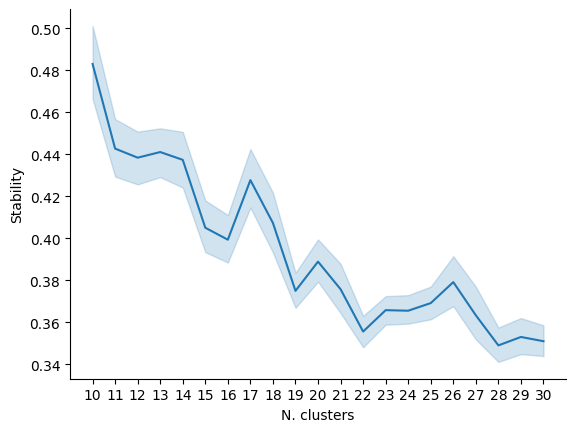

The optimal number of clusters was selected to be 10


In [30]:
# RESULTS
cc.pl.autok_stability(autok)
plt.show()

best_k = autok.best_k
print(f"The optimal number of clusters was selected to be {best_k}")

In [31]:
# assign the computed clusters
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


## 4) Cluster Analysis

#### 4.1 PCA

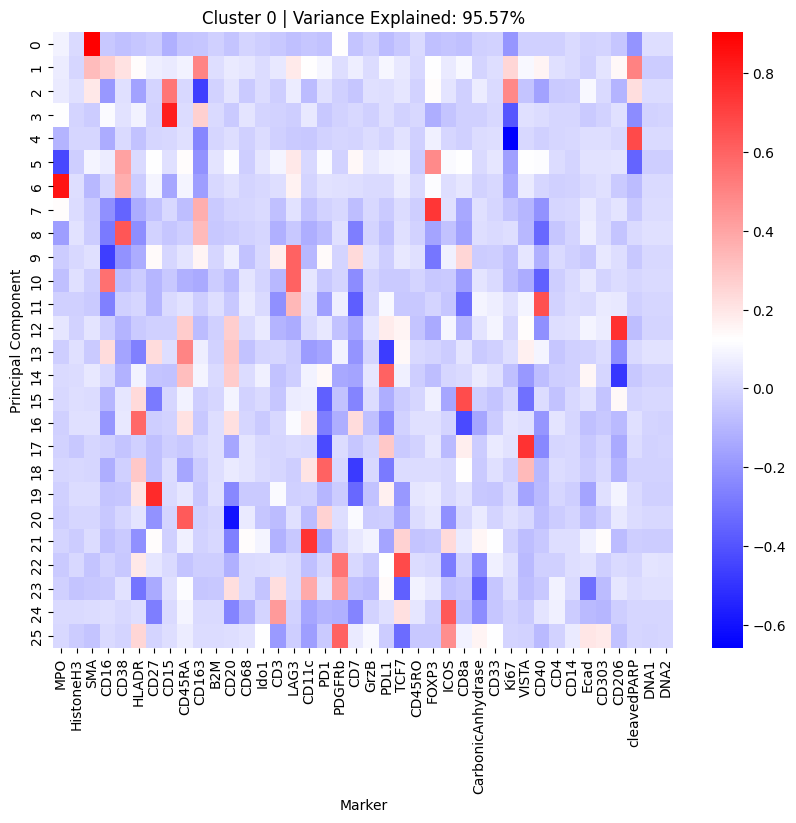

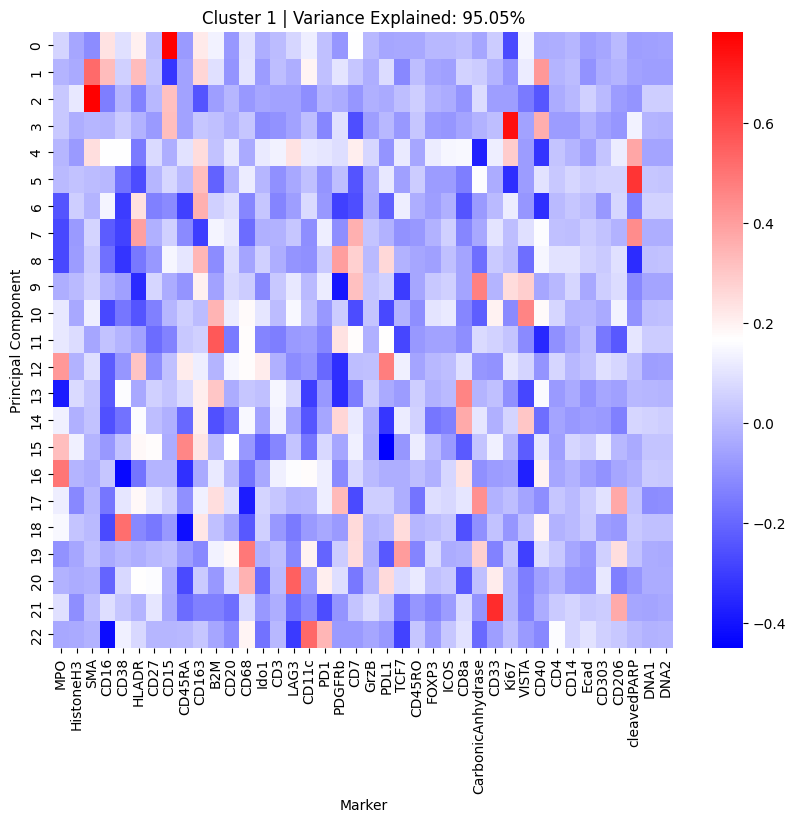

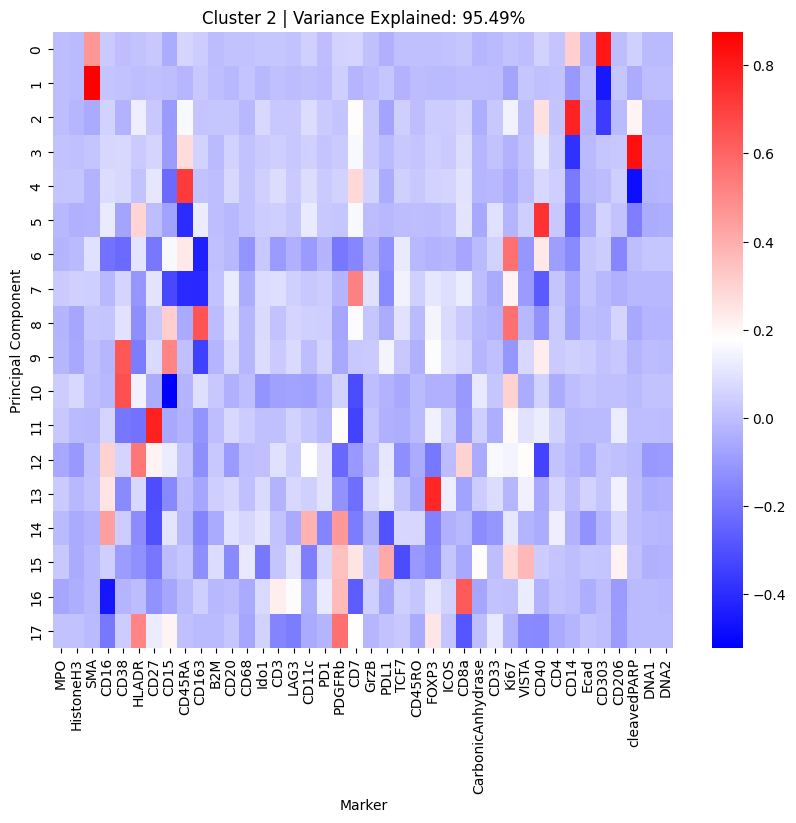

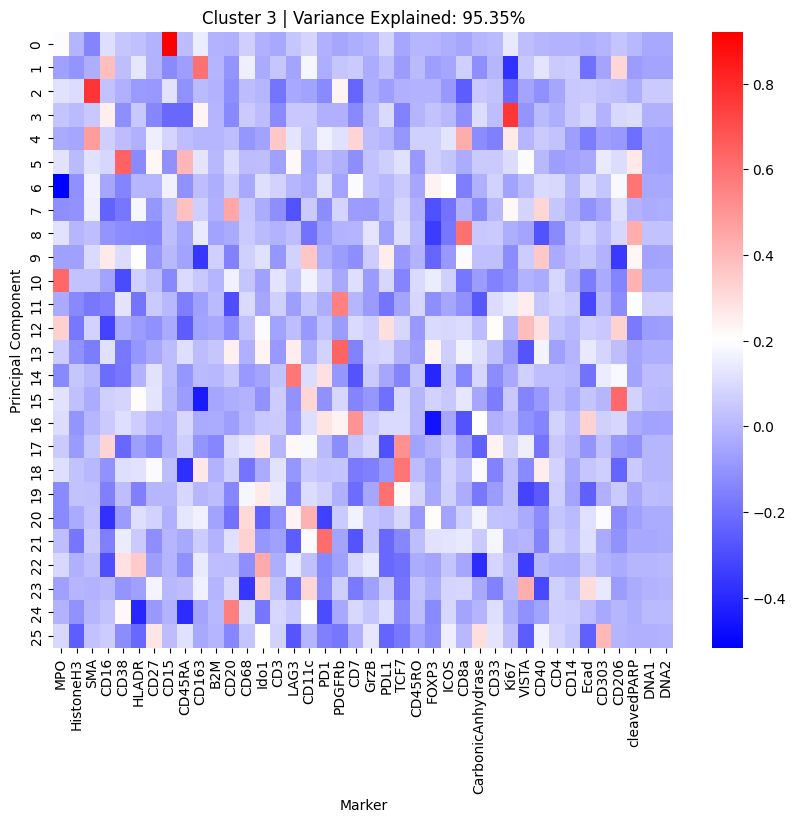

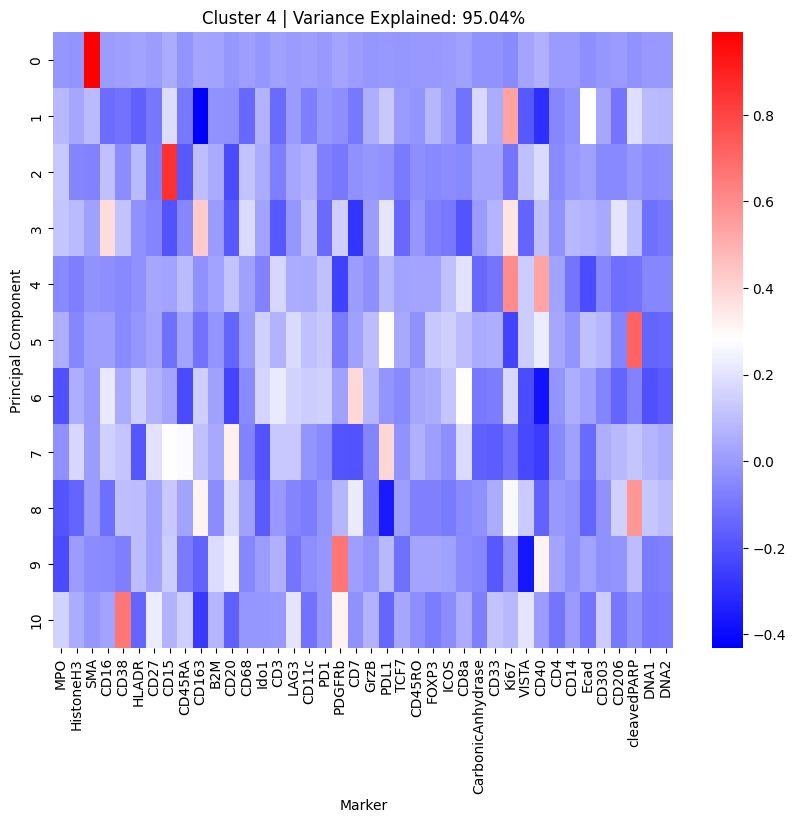

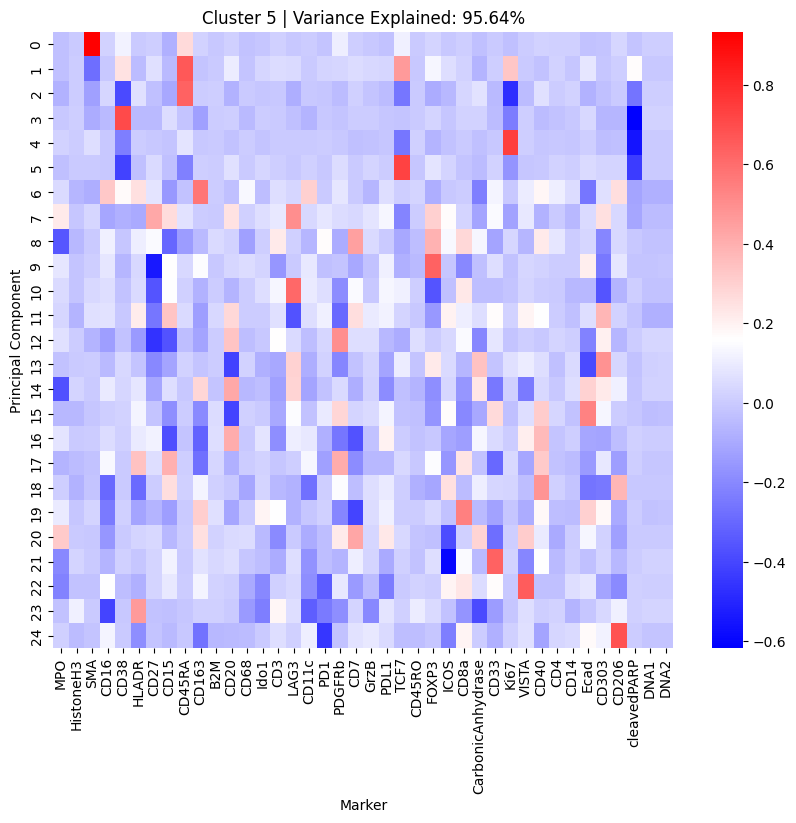

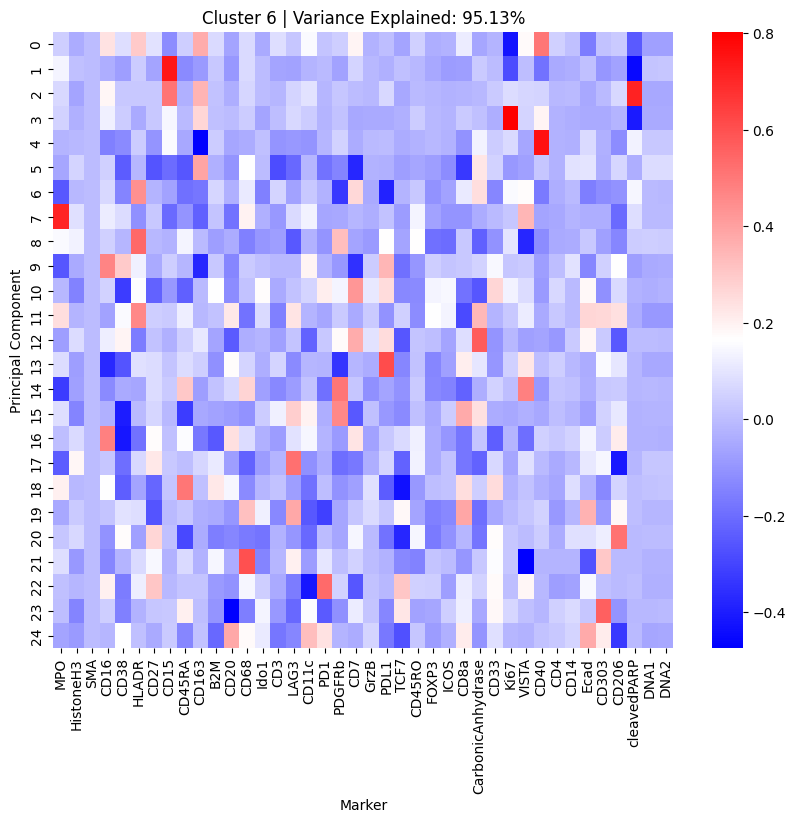

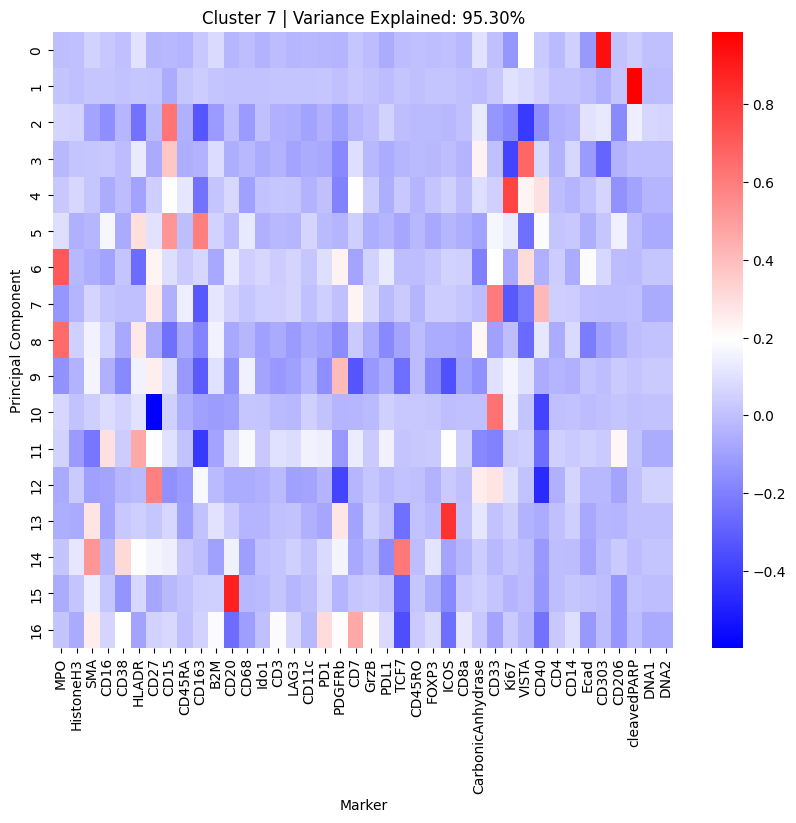

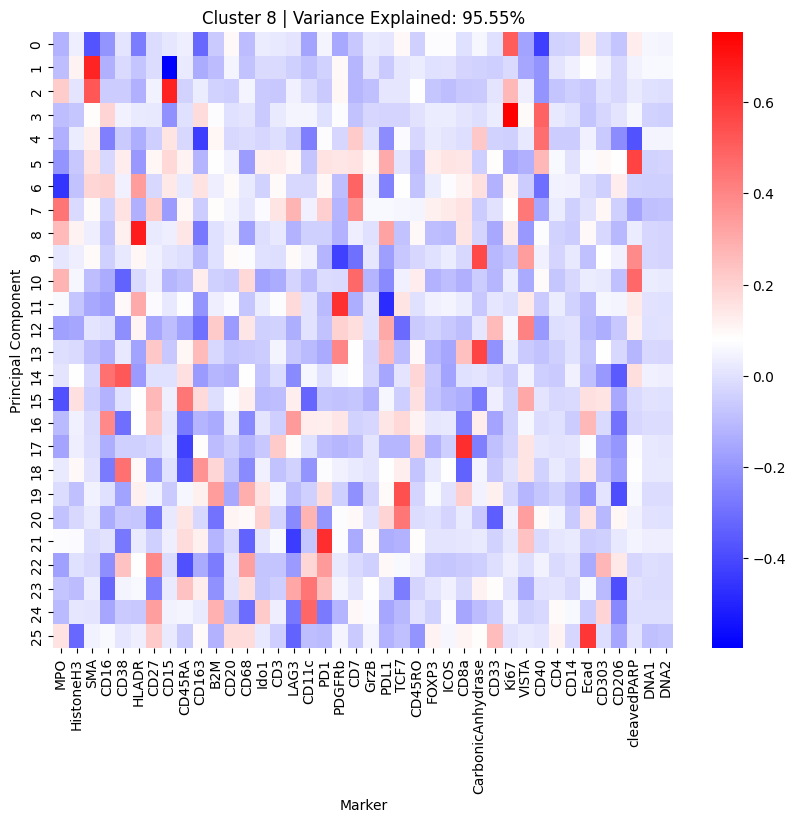

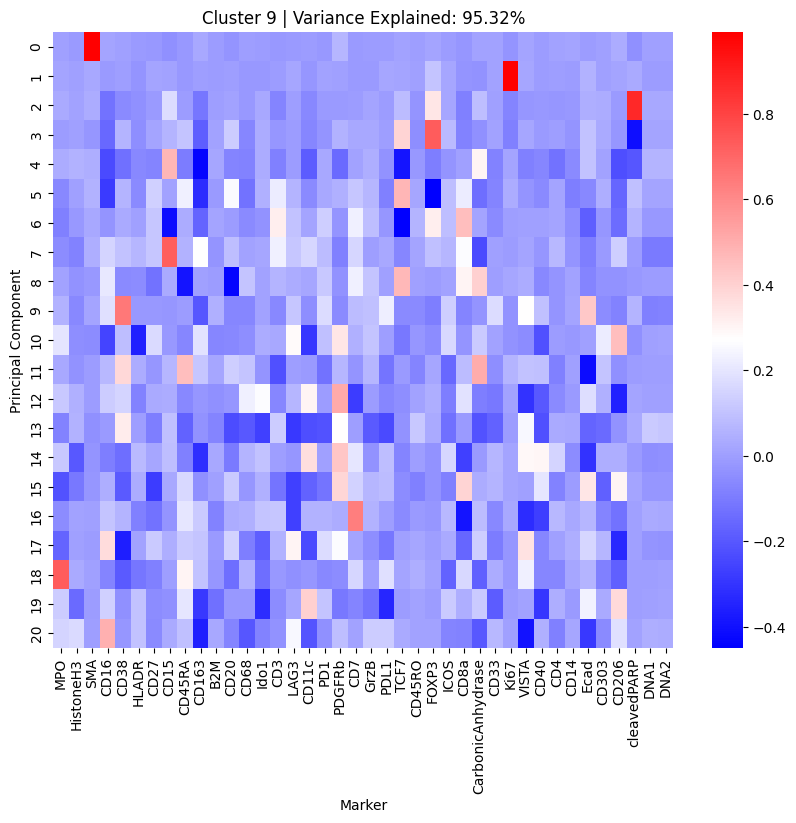

In [32]:
# PCA on ech of the clusters

for i in range(best_k):
    mask = adata.obs['cluster_cellcharter'] == i

    cluster_exprs = adata.layers['exprs_normalized'][mask,:]
    pca = PCA(n_components = 0.95, svd_solver='full')
    cluster_exprs_pca = pca.fit_transform(cluster_exprs)



    plt.figure(figsize=(10, 8))
    sns.heatmap(pca.components_, cmap="bwr", xticklabels=adata.var['marker'])

    var_explained = pca.explained_variance_ratio_.sum()
    plt.title(f'Cluster {i} | Variance Explained: {var_explained:.2%}')    
    plt.xlabel('Marker')
    plt.ylabel('Principal Component')
    plt.show()


As we can see, there is a lot of variation in the number of principal components needed to explain 95% of variance. The number of PCs between clusters ranges from 11 to as high as 26.

#### 4.2) Cell type abundance analysis

In [33]:
celltype_abundance = (
    adata.obs
    .groupby(['cluster_cellcharter', 'celltypes'])
    .size()
    .unstack(fill_value=0)
)
celltype_fraction = celltype_abundance.apply(lambda x: x / x.sum(), axis=1)


/tmp/ipykernel_15872/9998892.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['cluster_cellcharter', 'celltypes'])


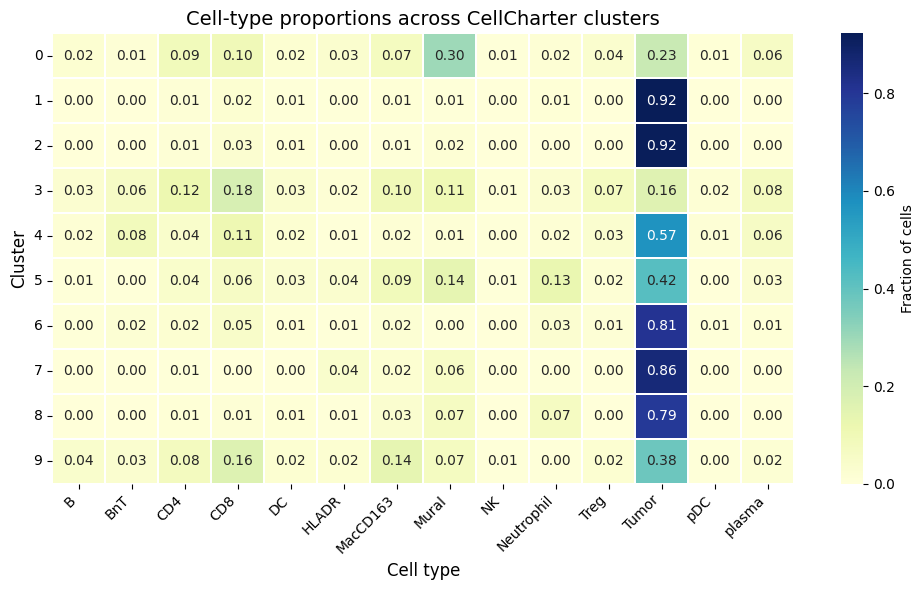

In [35]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    celltype_fraction,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.3,
    cbar_kws={"label": "Fraction of cells"},
)

plt.title("Cell-type proportions across CellCharter clusters", fontsize=14)
plt.xlabel("Cell type", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

The tumor cells are present in every cluster, and in 6 of the 10 clusters they constitute a majority. Interistingly, the tumor abundance is inversely proportional to the CD8 cell abundance. This observation is in line with our current knowledge on the role of the immune system in cancer supression

#### 4.3) Mean marker expression analysis

/tmp/ipykernel_15872/2739744130.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clusters_avg_exprs_df = expr_df.groupby('cluster').mean()


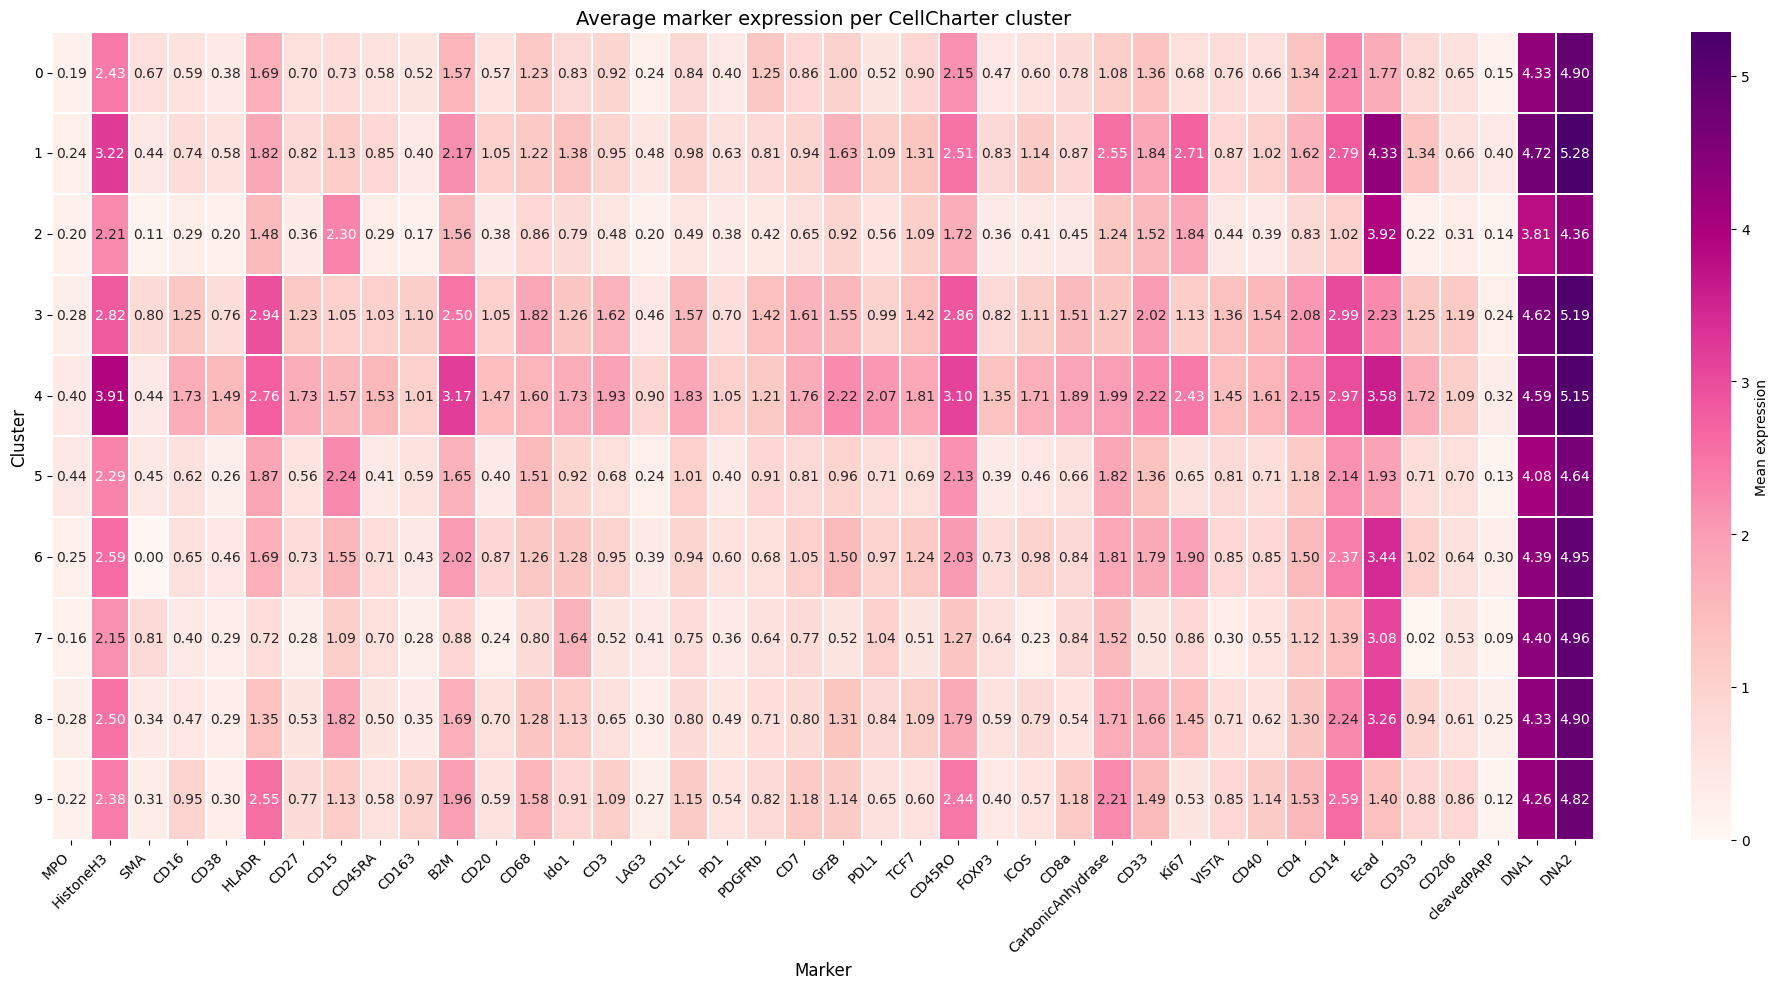

In [36]:
# Convert the matrix to a DataFrame with appropriate labels
expr_df = pd.DataFrame(
    adata.layers['exprs'],
    columns=adata.var['marker'],
    index=adata.obs_names
)
expr_df['cluster'] = adata.obs['cluster_cellcharter'].values

# Group by cluster and compute mean per marker
clusters_avg_exprs_df = expr_df.groupby('cluster').mean()

# Heatmap for markers' means for each cluster

plt.figure(figsize=(20, 10))
sns.heatmap(
    clusters_avg_exprs_df,
    cmap="RdPu",
    annot=True,# if clusters_avg_exprs_df.shape[1] <= 20 else False,
    fmt='.2f',
    cbar_kws={"label": "Mean expression"},
    linewidths=0.3
)

plt.title("Average marker expression per CellCharter cluster", fontsize=14)
plt.xlabel("Marker", fontsize=12)
plt.ylabel("Cluster", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

DNA1 and DNA2 have the highest mean expression which is not extraordinary. Other markers' expressions vary a lot across clusters. Interestingly, Ecad expressions are much higher in the clusters which are all havily dominated by tumor cells

In [37]:
adata

AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier', 'cluster_cellcharter', 'dummy'
    var: 'channel', 'use_channel', 'marker'
    uns: 'spatial_neighbors'
    obsm: 'X_PCA', 'spatial', 'X_cellcharter'
    layers: 'exprs', 'exprs_normalized'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [39]:
# clustering for mean marker and cell type histogram done earlier during classes


# finding mean marker expression
avg_marker_expression = []
for i in range(len(adata.obs)):

  # finding neighbors
  neighbors = adata.obsp['spatial_connectivities'][i].indices

  # adding yourself as a neighbor
  neighbors_lis=list(neighbors)
  neighbors_lis.append(i)
  neighbors=np.array(neighbors_lis)

  # finding mean expression in neighbors
  avg_expression = np.mean(adata.layers['exprs'][neighbors], axis=0)
  avg_marker_expression.append(avg_expression)

# merging results
avg_marker_expression = np.stack(avg_marker_expression)


# finding cell types histograms

# creating onehots where each cell has a 1 in column of its celltype
adata.obs['dummy'] = 1
cell_type_onehots=pd.pivot_table(adata.obs, values='dummy', index=adata.obs.index, columns=['celltypes'], aggfunc=np.sum)
cell_type_onehots=cell_type_onehots.loc[adata.obs.index] # fixing the order


neigh_hist = []
for i in range(len(adata.obs)):

  # finding neighbors
  neighbors = adata.obsp['spatial_connectivities'][i].indices

  # adding yourself as a neighbor
  neighbors_lis=list(neighbors)
  neighbors_lis.append(i)
  neighbors=np.array(neighbors_lis)

  # summing cell types
  sum_neigh = np.sum(cell_type_onehots.values[neighbors], axis=0)
  neigh_hist.append(sum_neigh)

# merging results
neigh_hist = np.stack(neigh_hist)

# enriching data
adata.obsm['avg_marker_expression'] = avg_marker_expression
adata.obsm['cell_type_hist'] = neigh_hist

# models for clustering with finding best number of clusters
models_avg_expr = cc.tl.ClusterAutoK(n_clusters=range(10,30), model_class=cc.tl.GaussianMixture, model_params=model_params, max_runs=5)
models_cell_type_hist = cc.tl.ClusterAutoK(n_clusters=range(10,30), model_class=cc.tl.GaussianMixture, model_params=model_params, max_runs=5)

adata.obsm["avg_marker_expression"] = adata.obsm["avg_marker_expression"].astype(np.float32)
models_avg_expr.fit(adata[::10], use_rep='avg_marker_expression')

adata.obsm["cell_type_hist"] = adata.obsm["cell_type_hist"].astype(np.float32)
models_cell_type_hist.fit(adata[::10], use_rep='cell_type_hist')

n_clusters_avg_expr = models_avg_expr.best_k
n_clusters_hist = models_cell_type_hist.best_k

# running predictions

adata.obs['clusters_marker'] = models_avg_expr.predict(adata, use_rep='avg_marker_expression', k=n_clusters_avg_expr)
adata.obs['clusters_hist'] = models_cell_type_hist.predict(adata, use_rep='cell_type_hist', k=n_clusters_hist)

/tmp/ipykernel_15872/3550239861.py:28: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  cell_type_onehots=pd.pivot_table(adata.obs, values='dummy', index=adata.obs.index, columns=['celltypes'], aggfunc=np.sum)
/tmp/ipykernel_15872/3550239861.py:28: FutureWarning: The provided callable <function sum at 0x75cff076c400> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  cell_type_onehots=pd.pivot_table(adata.obs, values='dummy', index=adata.obs.index, columns=['celltypes'], aggfunc=np.sum)


Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEV

Iteration 1/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 2/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 3/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 4/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

Iteration 5/5


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=19` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=1` r

## 5) Cross-count Matrices

In [65]:
def plot_pretty_heatmap(data, title, xlabel, ylabel, fmt='d', cmap='rocket_r', figsize=(18, 8), cbar_label=None):
    plt.figure(figsize=figsize)
    sns.heatmap(
        data,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        linewidths=0.3,
        cbar_kws={"label": cbar_label} if cbar_label else None
    )
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


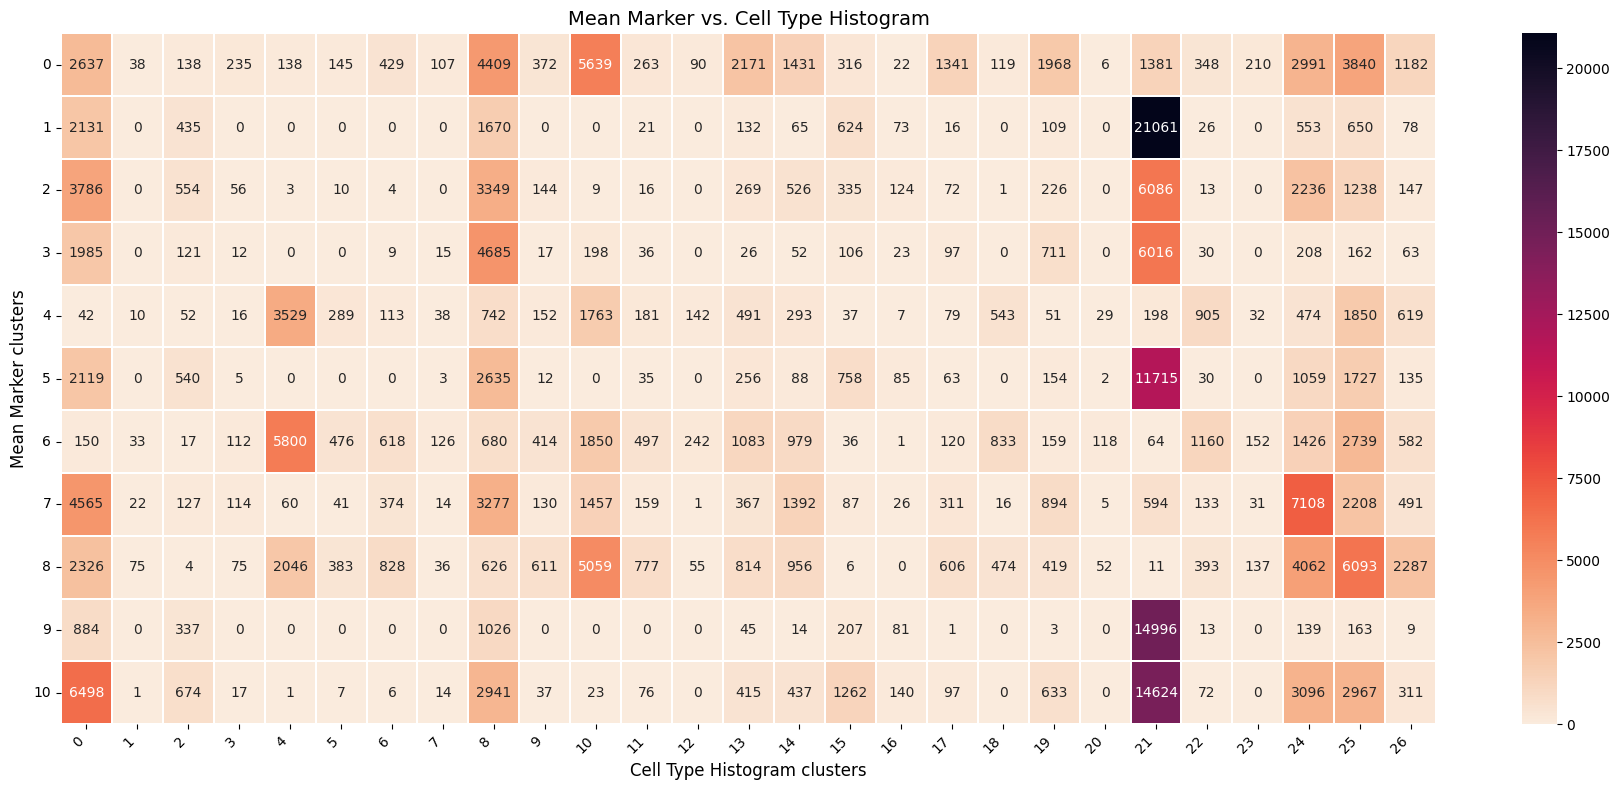

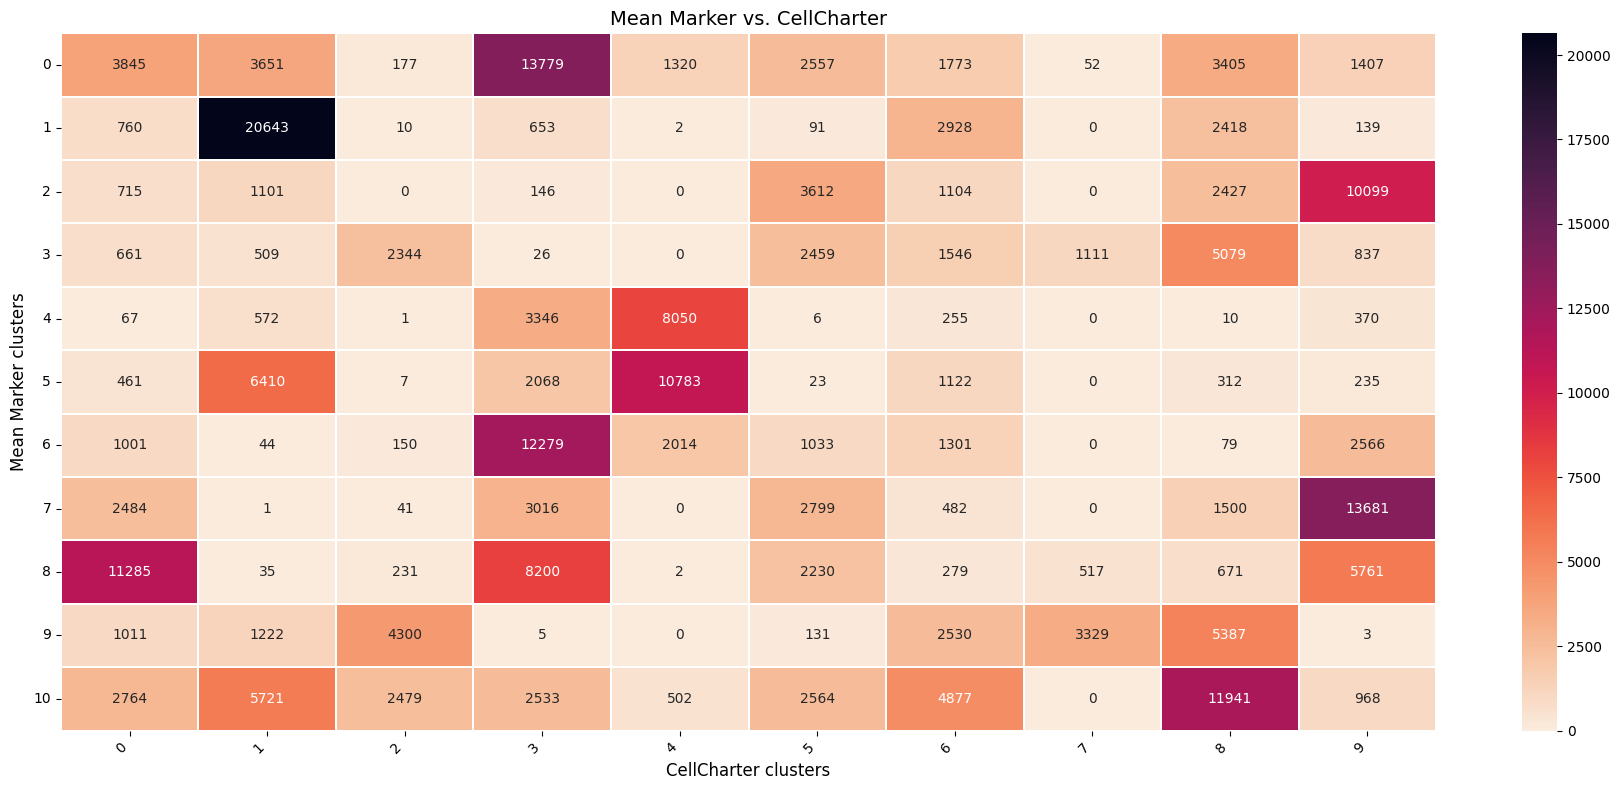

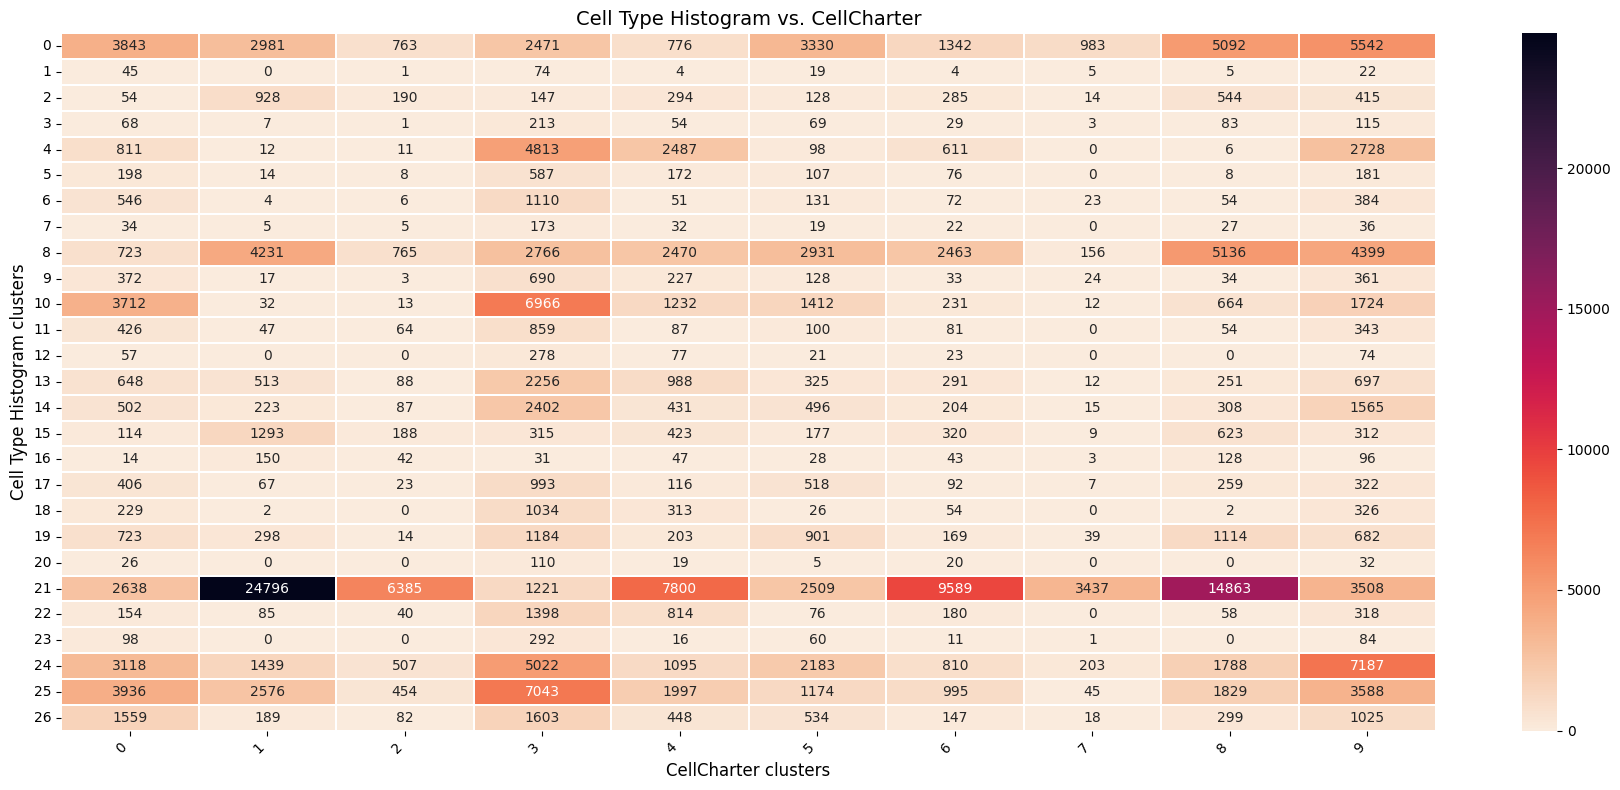

In [66]:
# Mean marker vs. Cell type histogram
markers_hists_cross_count = pd.crosstab(adata.obs['clusters_marker'], adata.obs['clusters_hist'])
plot_pretty_heatmap(
    markers_hists_cross_count,
    title='Mean Marker vs. Cell Type Histogram',
    xlabel='Cell Type Histogram clusters',
    ylabel='Mean Marker clusters',
)

# Mean marker vs. CellCharter
markers_cellcharter_cross_count = pd.crosstab(adata.obs['clusters_marker'], adata.obs['cluster_cellcharter'])
plot_pretty_heatmap(
    markers_cellcharter_cross_count,
    title='Mean Marker vs. CellCharter',
    xlabel='CellCharter clusters',
    ylabel='Mean Marker clusters',
)

# Cell type histogram vs. CellCharter
hists_cellcharter_cross_count = pd.crosstab(adata.obs['clusters_hist'], adata.obs['cluster_cellcharter'])
plot_pretty_heatmap(
    hists_cellcharter_cross_count,
    title='Cell Type Histogram vs. CellCharter',
    xlabel='CellCharter clusters',
    ylabel='Cell Type Histogram clusters',
)
